**ORIGINAL POST URL:** http://blog.christianperone.com/tag/convolutional-neural-network/

## Deep learning – Convolutional neural networks and feature extraction with Python

Convolutional neural networks (or [ConvNets](https://en.wikipedia.org/wiki/Convolutional_neural_network)) are biologically-inspired variants of MLPs, they have different kinds of layers and each different layer works different than the usual MLP layers. If you are interested in learning more about ConvNets, a good course is the [CS231n – Convolutional Neural Newtorks for Visual Recognition](http://cs231n.github.io/convolutional-networks/). The architecture of the CNNs are shown in the images below:

![CNN](http://blog.christianperone.com/wp-content/uploads/2015/08/neural_net2.jpeg)
### A regular neural network (from CS231n website).

![CNN](http://blog.christianperone.com/wp-content/uploads/2015/08/cnn.jpeg)
### A ConvNet network achitecture (from CS231n website).

As you can see, the ConvNets works with 3D volumes and transformations of these 3D volumes. I won’t repeat in this post the entire CS231n tutorial, so if you’re really interested, please take time to read before continuing.

### Lasagne and nolearn

One of the Python packages for deep learning that I really like to work with is [Lasagne](https://github.com/Lasagne/Lasagne) and [nolearn](https://github.com/dnouri/nolearn). Lasagne is based on Theano so the GPU speedups will really make a great difference, and their declarative approach for the neural networks creation are really helpful. The nolearn libary is a collection of utilities around neural networks packages (including Lasagne) that can help us a lot during the creation of the neural network architecture, inspection of the layers, etc.

What I’m going to show in this post, is how to build a simple ConvNet architecture with some convolutional and pooling layers. I’m also going to show how you can use a ConvNet to train a feature extractor and then use it to extract features before feeding them into different models like SVM, Logistic Regression, etc. Many people use pre-trained ConvNet models and then remove the last output layer to extract the features from ConvNets that were trained on ImageNet datasets. This is usually called transfer learning because you can use layers from other ConvNets as feature extractors for different problems, since the first layer filters of the ConvNets works as edge detectors, they can be used as general feature detectors for other problems.



### Loading the MNIST dataset

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset is one of the most traditional datasets for digits classification. We will use a pickled version of it for Python, but first, lets import the packages that we will need to use:

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from urllib import urlretrieve
import cPickle as pickle
import os
import gzip
import numpy as np
import theano
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

As you can see, we are importing matplotlib for plotting some images, some native Python modules to download the MNIST dataset, numpy, theano, lasagne, nolearn and some scikit-learn functions for model evaluation.

After that, we define our MNIST loading function (this is pretty the same function used in the Lasagne tutorial):

In [2]:
def load_dataset():
    url = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'
    filename = 'mnist.pkl.gz'
    if not os.path.exists(filename):
        print("Downloading MNIST dataset...")
        urlretrieve(url, filename)
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)
    X_train, y_train = data[0]
    X_val, y_val = data[1]
    X_test, y_test = data[2]
    X_train = X_train.reshape((-1, 1, 28, 28))
    X_val = X_val.reshape((-1, 1, 28, 28))
    X_test = X_test.reshape((-1, 1, 28, 28))
    y_train = y_train.astype(np.uint8)
    y_val = y_val.astype(np.uint8)
    y_test = y_test.astype(np.uint8)
    return X_train, y_train, X_val, y_val, X_test, y_test

As you can see, we are downloading the MNIST pickled dataset and then unpacking it into the three different datasets: train, validation and test. After that we reshape the image contents to prepare them to input into the Lasagne input layer later and we also convert the numpy array types to uint8 due to the GPU/theano datatype restrictions.



After that, we’re ready to load the MNIST dataset and inspect it:

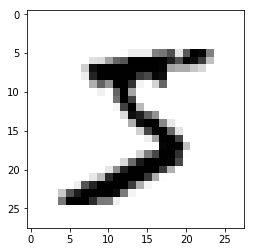

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
plt.imshow(X_train[0][0], cmap=cm.binary)

### ConvNet Architecture and Training

Now we can define our ConvNet architecture and then train it using a GPU/CPU (I have a very cheap GPU, but it helps a lot):

In [6]:
net1 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer
    input_shape=(None, 1, 28, 28),
    # layer conv2d1
    conv2d1_num_filters=32,
    conv2d1_filter_size=(5, 5),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),  
    # layer maxpool1
    maxpool1_pool_size=(2, 2),    
    # layer conv2d2
    conv2d2_num_filters=32,
    conv2d2_filter_size=(5, 5),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    # layer maxpool2
    maxpool2_pool_size=(2, 2),
    # dropout1
    dropout1_p=0.5,    
    # dense
    dense_num_units=256,
    dense_nonlinearity=lasagne.nonlinearities.rectify,    
    # dropout2
    dropout2_p=0.5,    
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=10,
    # optimization method params
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,
    max_epochs=10,
    verbose=1,
    )
# Train the network
nn = net1.fit(X_train, y_train)

/Users/guilherme/anaconda/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 160362 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x28x28
  1  conv2d1   32x24x24
  2  maxpool1  32x12x12
  3  conv2d2   32x8x8
  4  maxpool2  32x4x4
  5  dropout1  32x4x4
  6  dense     256
  7  dropout2  256
  8  output    10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.81892     0.17231    4.75259      0.95032  51.44s
      2     0.27619     0.11164    2.47379      0.96672  49.41s
      3     0.20240     0.08891    2.27645      0.97361  52.12s
      4     0.16804     0.07600    2.21107      0.97731  44.61s
      5     0.14829     0.06724    2.20534      0.98071  45.65s
      6     0.12962     0.05989    2.16410      0.98251  44.22s
      7     0.11440     0.05560    2.05748      0.98401  43.77s
      8     0.10475     0.05482    1.91070      0.98371  47.33s
      9     0.09932     0.05227    1.90005      0.98

As you can see, in the parameter layers we’re defining a dictionary of tuples with the layer names/types and then we define the parameters for these layers. Our architecture here is using two convolutional layers with poolings and then a fully connected layer (dense layer) and the output layer. There are also dropouts between some layers, the dropout layer is a regularizer that randomly sets input values to zero to avoid overfitting (see the image below).

![dropout](http://blog.christianperone.com/wp-content/uploads/2015/08/dropout.jpeg)

### Prediction and Confusion Matrix



Now we can use the model to predict the entire testing dataset:

In [7]:
preds = net1.predict(X_test)

And we can also plot a confusion matrix to check the performance of the neural network classification:

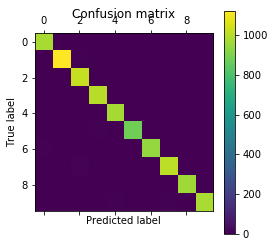

In [8]:
cm = confusion_matrix(y_test, preds)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As you can see, the diagonal is where the classification is more dense, showing the good performance of our classifier.

### Filters Visualization

We can also visualize the 32 filters from the first convolutional layer:

<module 'matplotlib.pyplot' from '/Users/guilherme/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

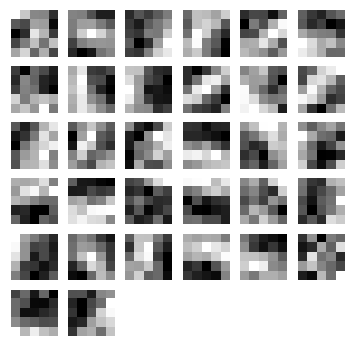

In [9]:
visualize.plot_conv_weights(net1.layers_['conv2d1'])

As you can see, the nolearn plot_conv_weights plots all the filters present in the layer we specified.

### Theano layer functions and Feature Extraction

Now it is time to create theano-compiled functions that will feed-forward the input data into the architecture up to the layer you’re interested. I’m going to get the functions for the output layer and also for the dense layer before the output layer:

In [10]:
dense_layer = layers.get_output(net1.layers_['dense'], deterministic=True)
output_layer = layers.get_output(net1.layers_['output'], deterministic=True)
input_var = net1.layers_['input'].input_var
f_output = theano.function([input_var], output_layer)
f_dense = theano.function([input_var], dense_layer)

As you can see, we have now two theano functions called f_output and f_dense (for the output and dense layers). Please note that in order to get the layers here we are using a extra parameter called “deterministic“, this is to avoid the dropout layers affecting our feed-forward pass.



We can now convert an example instance to the input format and then feed it into the theano function for the output layer:



In [12]:
instance = X_test[0][None, :, :]
%timeit -n 500 f_output(instance)

500 loops, best of 3: 468 µs per loop


As you can see, the f_output function takes an average of 858 µs. We can also plot the output layer activations for the instance:

<Container object of 10 artists>

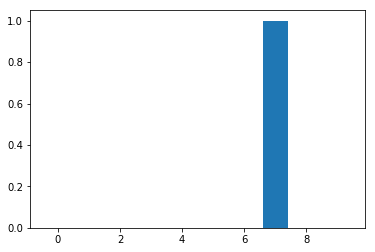

In [13]:
pred = f_output(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())

As you can see, the digit was recognized as the digit 7. The fact that you can create theano functions for any layer of the network is very useful because you can create a function (like we did before) to get the activations for the dense layer (the one before the output layer) and you can use these activations as features and use your neural network not as classifier but as a feature extractor. Let’s plot now the 256 unit activations for the dense layer:

<Container object of 256 artists>

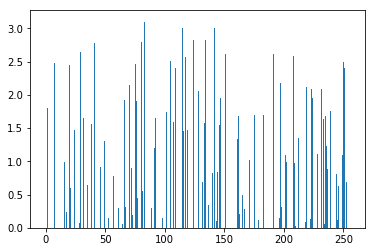

In [14]:
pred = f_dense(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())

You can now use the output of the these 256 activations as features on a linear classifier like Logistic Regression or SVM.

## TRY TO CONTINUE USING OUR DATASET